In [91]:
import pandas as pd
import numpy as np
import copy
import random
from math import sqrt
import scipy.stats as sts

from tqdm import tqdm_notebook

from supplement_package import game
from supplement_package import variables_pecan

pd.options.mode.chained_assignment = None  # default='warn'

In [92]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [93]:
from supplement_package.game.stackelberg import StackelbergPlayer

In [94]:
import gurobipy as gp

from supplement_package.gurobi_implementation.gurobi import GurobiSolution


In [95]:
agent_keys = [661, 1642, 2335, 2361, 2818, 3039, 3456, 3538, 4031, 4373, 4767, 5746, 6139, 7536, 7719, 7800, 7901, 7951, 8156, 8386, 8565, 9019, 9160, 9922, 9278]

dataframe_dict = dict()
for key in agent_keys:
    dataframe_dict.update({key : pd.read_csv('/Users/ishilov/Documents/risk_paper/risk_paper/data/df_{}.csv'.format(key))})

community_size = len(dataframe_dict)

for key in agent_keys:
    cond_min = (dataframe_dict[key]['demand'].quantile(0.001) <= dataframe_dict[key]['demand'])
    cond_max = (dataframe_dict[key]['demand'] <= dataframe_dict[key]['demand'].quantile(0.999))
    dataframe_dict[key] = dataframe_dict[key][cond_min & cond_max]

In [96]:
def generate_new_params(sample_size, community_size):
    res = {}

    for sample in range(sample_size):
        A_tilde = [random.uniform(0,1) for i in range(community_size)]
        B_tilde = [random.uniform(0,1) for i in range(community_size)]

        a = [random.uniform(0,1) for i in range(community_size)]
        b = [random.uniform(0,1) for i in range(community_size)]
        d = [random.uniform(0,1) for i in range(community_size)]

        #d_target = [[random.uniform(0,8) for j in range(len(probabilities))] for i in range(community_size)]
        #g_res = [[random.uniform(0,3) for j in range(len(probabilities))] for i in range(community_size)]

        #g_res = np.array(g_res)
        #d_target = np.array(d_target)

        risk_aversion = [random.uniform(0,1) for i in range(community_size)]

        res.update({sample : {'A_tilde' : A_tilde,
                        'B_tilde' : B_tilde,
                        'a' : a,
                        'b' : b,
                        'd' : d,
                        'risk_aversion' : risk_aversion}})

    res_reformed = {(i, key) : res[i][key] for i in range(sample_size) for key in res[0].keys()}
    mindx = pd.MultiIndex.from_tuples(res_reformed.keys())
    df = pd.DataFrame(list(res_reformed.values()), index = mindx)
    df.to_csv(f'../data/param_{sample_size}.csv')

In [97]:
def text_to_adj_matrix(matrix_path):
    res = []
    with open(matrix_path) as file:
        for s in file:
            string = ''.join(s.strip().strip(',').split(', '))
            lst_temp = [int(sym) for sym in string]

            res.append(lst_temp)

    return res

In [98]:
def read_df_param(sample_size):
    df_param = pd.read_csv(f'../data/param_{sample_size}.csv')
    df_param.rename({'Unnamed: 0' : 'Sample', 'Unnamed: 1' : 'Parameter'}, axis=1, inplace= True)
    df_param.set_index(['Sample', 'Parameter'], inplace=True)

    return df_param

In [99]:
def distribution_build(sample_size, agent_keys):
    res = {}
    
    for key in agent_keys:
        #chunks_demand = int(demand_dict[key][0].size / sample_size)
        #chunks_generation = int(solar_dict[key][0].size / sample_size)


        #probas_demand = [np.trapz(demand_dict[key][1][i * sample_size : (i + 1) * sample_size],
        #                            demand_dict[key][0][i * sample_size : (i + 1) * sample_size])
        #                            for i in range(chunks_demand)]

        #probas_generation = [np.trapz(generation_dict[key][1][i * sample_size : (i + 1) * sample_size],
        #                            generation_dict[key][0][i * sample_size : (i + 1) * sample_size])
        #                            for i in range(chunks_generation)]

        #res_demand = plt.hist(np.random.choice(demand_dict[key][0], size = sample_size, p = probabilities), bins = int(sample_size / 2))
        #probas_update = res_demand[0] / res_demand[0].sum() if key == 661 else res[661]['probabilities']
        #res.update({key : 
        #            {'values' : res_demand[1], 
        #            'probabilities' : probas_update}})

        hist_demand = plt.hist(dataframe_dict[key]['demand'], bins = sample_size)
        probas_demand, values_demand = hist_demand[0], hist_demand[1]
        probas_demand = probas_demand / probas_demand.sum()

        if 'solar' in dataframe_dict[key].columns:
            hist_solar = plt.hist(dataframe_dict[key][dataframe_dict[key]['solar'] >= 0]['solar'], bins = sample_size)
            probas_solar , values_solar  = hist_solar[0], hist_solar[1]
            probas_solar = probas_demand / probas_demand.sum()

        res.update({key : 
                    {'probas_demand' : probas_demand,
                    'values_demand' : values_demand,
                    'probas_solar' : probas_solar,
                    'values_solar' : values_solar}})

    return res 


In [100]:
def scenario_sampling(sample_size, agent_keys, main_key = 661):
    distribution = distribution_build(sample_size, agent_keys)

    probabilities = distribution[main_key]['probas_demand']

    d_target = []
    g_res = []
    for key in agent_keys:
        d_target.append(distribution[key]['values_demand'][:-1])
        g_res.append(distribution[key]['values_solar'][:-1])

    return probabilities, d_target, g_res

In [101]:
def param_input(df, index = 0):
    A_tilde = list(df.loc[index].loc['A_tilde'])
    B_tilde = list(df.loc[index].loc['B_tilde'])
    a = list(df.loc[index].loc['a'])
    b = list(df.loc[index].loc['b'])
    d = list(df.loc[index].loc['d'])
    risk_aversion = list(df.loc[index].loc['risk_aversion'])

    return A_tilde, B_tilde, a, b, d, risk_aversion

In [102]:
param_amount = 1

#generate_new_params(param_amount,community_size=community_size)
df_param = read_df_param(param_amount)

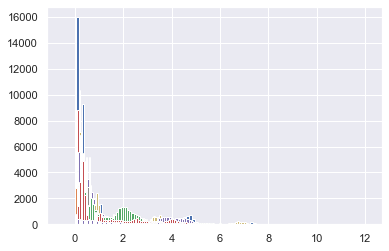

In [103]:
probabilities, d_target, g_res = scenario_sampling(100, agent_keys)
A_tilde, B_tilde, a, b, d, risk_aversion = param_input(df_param)

In [111]:
def agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix, d_target, g_res):
    agents = []
    StackelbergPlayer.community_size = community_size
    StackelbergPlayer.probabilities = probabilities

    epsilon = 0.001
    alpha = [[proba/(1 - min(risk_aversion)) - epsilon for proba in probabilities] for i in range(community_size)]
    #alpha = [[0.2 for proba in probabilities] for i in range(community_size)]
    gamma = [proba/(1 - min(risk_aversion)) for proba in probabilities]

    j_max = [10 for i in range(community_size)]

    for i in range(community_size):
        agent = StackelbergPlayer(i, d_target[i], g_res[i], a[i], b[i], d[i], 
                    A_tilde[i], B_tilde[i], D_min[i], D_max[i], 
                    G_min[i], G_max[i], risk_aversion[i], Kappa[i], Cost[i], connection_matrix[i],
                    probabilities = probabilities,
                    alpha = alpha[i], 
                    gamma = gamma, 
                    insurance_bound=j_max[i])
        
        agents.append(agent)

    return agents

In [112]:
def agents_list_optimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix, d_target, g_res):
    agents = []
    StackelbergPlayer.community_size = community_size
    StackelbergPlayer.probabilities = probabilities

    epsilon = 0.001
    alpha = [[proba/(1 - min(risk_aversion)) for proba in probabilities] for i in range(community_size)]
    #alpha = [[0.2 for proba in probabilities] for i in range(community_size)]
    gamma = [100000 for proba in probabilities]

    j_max = [10 for i in range(community_size)]

    for i in range(community_size):
        agent = StackelbergPlayer(i, d_target[i], g_res[i], a[i], b[i], d[i], 
                    A_tilde[i], B_tilde[i], D_min[i], D_max[i], 
                    G_min[i], G_max[i], risk_aversion[i], Kappa[i], Cost[i], connection_matrix[i],
                    probabilities = probabilities,
                    alpha = alpha[i], 
                    gamma = gamma, 
                    insurance_bound=j_max[i])
        
        agents.append(agent)

    return agents

In [113]:
def vars_to_dict(model, list_vars):
    var_names = []
    
    for var in model.getVars():
        var_names.append(var.VarName)

    dict_res = {}
    for name, var in zip(var_names, list_vars):
        dict_res.update({name : var})

    return dict_res

In [114]:
def gurobi_experiment(df_param, index, err_track, agents, solution_type):
    #A_tilde, B_tilde, a, b, d, risk_aversion = param_input(df_param, index = index)

    model_1 = gp.Model()
    setup = GurobiSolution(agents=agents,
                    model = model_1,
                    solution_type=solution_type)

    model_1.setParam('OutputFlag', 1)

    setup.build_model()

    try:
        model_1.optimize()

        list_vars = model_1.X
        dict_vars = vars_to_dict(model_1, list_vars)
        objective_val = model_1.getObjective().getValue()
        
        
        
    except:
        err_track.append(index)
        list_vars = ['err']
        objective_val = 'err'
        dict_vars = vars_to_dict(model_1, list_vars)

    return dict_vars, objective_val, model_1

In [115]:
D_min = [0 for i in range(community_size)]
D_max = [dataframe_dict[i].demand.max() for i in dataframe_dict.keys()]

G_min = [0 for i in range(community_size)]
G_max = [dataframe_dict[i].grid.max() for i in dataframe_dict.keys()]

Kappa = [[10 if i!=j else 0 for i in range(community_size)] for j in range(community_size)]

Cost = [[1 for i in range(community_size)] for j in range(community_size)]

In [116]:
connection_matrix_1 = text_to_adj_matrix('../matrices/matrix_1.txt')
connection_matrix_2 = text_to_adj_matrix('../matrices/matrix_2.txt')
connection_matrix_3 = text_to_adj_matrix('../matrices/matrix_3.txt')
connection_matrix_4 = text_to_adj_matrix('../matrices/matrix_4.txt')
connection_matrix_5 = text_to_adj_matrix('../matrices/matrix_5.txt')

## Experiment 1 

### Pessimistic

In [118]:
agents = agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix_1, d_target, g_res)

In [119]:
total_results_pessimistic = {}
err_track = []
for index in tqdm_notebook(df_param.index.levels[0]):
    vars, objective, model = gurobi_experiment(df_param, index, err_track, agents, solution_type='centralized_pessimistic')
    total_results_pessimistic.update({index: {'vars' : vars,
                                'objective' : objective}})

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/2105270090.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index in tqdm_notebook(df_param.index.levels[0]):


  0%|          | 0/1 [00:00<?, ?it/s]

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8000 rows, 17925 columns and 23700 nonzeros
Model fingerprint: 0x1f1ba6c8
Model has 2500 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-02, 1e+00]
  QLMatrix range   [2e-03, 2e+01]
  Objective range  [4e-05, 1e+01]
  Bounds range     [4e+00, 1e+01]
  RHS range        [1e-02, 9e+00]
  QRHS range       [6e-04, 8e+01]
Presolve removed 2700 rows and 875 columns
Presolve time: 0.01s
Presolved: 20300 rows, 22050 columns, 55325 nonzeros
Presolved model has 2500 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 25
 Free vars  : 2525
 AA' NZ     : 6.830e+04
 Factor NZ  : 2.099e+05 (roughly 20 MB of memory)
 Factor Ops : 2.663e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal

In [122]:
results_vars_pessimistic = pd.DataFrame(data = [list(total_results_pessimistic[0]['vars'].values())],
                                        columns=total_results_pessimistic[0]['vars'].keys())

results_vars_pessimistic['objective'] = total_results_pessimistic[0]['objective']

for i in tqdm_notebook(range(1, len(total_results_pessimistic))):
    df_temp = pd.DataFrame(data = [list(total_results_pessimistic[i]['vars'].values())],
                                        columns=total_results_pessimistic[i]['vars'].keys())
                            
    df_temp['objective'] = total_results_pessimistic[i]['objective']

    results_vars_pessimistic = pd.concat([results_vars_pessimistic, df_temp], ignore_index=True)

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/2122968484.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1, len(total_results_pessimistic))):


0it [00:00, ?it/s]

In [123]:
results_vars_pessimistic

,D_0_0,D_0_1,D_0_2,D_0_3,D_0_4,D_0_5,D_0_6,D_0_7,D_0_8,D_0_9,...,u_24_91,u_24_92,u_24_93,u_24_94,u_24_95,u_24_96,u_24_97,u_24_98,u_24_99,objective
0,4.825163e-10,1.964902e-09,0.008923,0.06691,0.122863,0.178746,0.234671,0.289839,0.342631,0.396478,...,6.489081e-08,4.492429e-08,7.300222e-08,4.492428e-08,7.300219e-08,3.893437e-08,6.489075e-08,9.733664e-08,9.733663e-08,-19.82688


In [124]:
total_results_pessimistic

{0: {'vars': {'D_0_0': 4.825162948163969e-10,
   'D_0_1': 1.9649015007369995e-09,
   'D_0_2': 0.008922883196885329,
   'D_0_3': 0.06690972493696262,
   'D_0_4': 0.12286341402167561,
   'D_0_5': 0.1787462762058153,
   'D_0_6': 0.23467086359222847,
   'D_0_7': 0.28983887504461436,
   'D_0_8': 0.3426309615343972,
   'D_0_9': 0.3964778082103995,
   'D_0_10': 0.4521414798061313,
   'D_0_11': 0.5071749529630244,
   'D_0_12': 0.5615949756647814,
   'D_0_13': 0.6160348460496586,
   'D_0_14': 0.6704683584976955,
   'D_0_15': 0.7249060586512402,
   'D_0_16': 0.7793398740506944,
   'D_0_17': 0.8335603108659019,
   'D_0_18': 0.8874822167302648,
   'D_0_19': 0.9414366880709242,
   'D_0_20': 0.9956527236498102,
   'D_0_21': 1.0499444563272433,
   'D_0_22': 1.1041589664046716,
   'D_0_23': 1.1609307753706528,
   'D_0_24': 1.2187252332294236,
   'D_0_25': 1.2765225660259558,
   'D_0_26': 1.334324278009008,
   'D_0_27': 1.3921090191573573,
   'D_0_28': 1.4498978490100651,
   'D_0_29': 1.507686486259654

### Optimistic

In [125]:
agents = agents_list_optimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix_1, d_target, g_res)

In [126]:
total_results_optimistic = {}
err_track = []
for index in tqdm_notebook(df_param.index.levels[0]):
    vars, objective, model = gurobi_experiment(df_param, index, err_track, agents, solution_type='centralized_optimistic')
    total_results_optimistic.update({index: {'vars' : vars,
                                'objective' : objective}})

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/2635634394.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index in tqdm_notebook(df_param.index.levels[0]):


  0%|          | 0/1 [00:00<?, ?it/s]

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10500 rows, 17925 columns and 26200 nonzeros
Model fingerprint: 0x9fab9e75
Model has 2500 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-02, 1e+00]
  QLMatrix range   [2e-03, 2e+01]
  Objective range  [2e-04, 1e+05]
  Bounds range     [4e+00, 1e+01]
  RHS range        [1e-02, 9e+00]
  QRHS range       [6e-04, 8e+01]
Presolve removed 5300 rows and 2500 columns
Presolve time: 0.01s
Presolved: 20200 rows, 20425 columns, 51200 nonzeros
Presolved model has 2500 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 25
 Free vars  : 25
 AA' NZ     : 6.580e+04
 Factor NZ  : 1.963e+05 (roughly 18 MB of memory)
 Factor Ops : 2.328e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal

In [127]:
results_vars_optimistic = pd.DataFrame(data = [list(total_results_optimistic[0]['vars'].values())],
                                        columns=total_results_optimistic[0]['vars'].keys())

results_vars_optimistic['objective'] = total_results_optimistic[0]['objective']

for i in tqdm_notebook(range(1, len(total_results_optimistic))):
    df_temp = pd.DataFrame(data = [list(total_results_optimistic[i]['vars'].values())],
                                        columns=total_results_optimistic[i]['vars'].keys())
                            
    df_temp['objective'] = total_results_optimistic[i]['objective']

    results_vars_optimistic = pd.concat([results_vars_optimistic, df_temp], ignore_index=True)

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/769426082.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1, len(total_results_optimistic))):


0it [00:00, ?it/s]

In [128]:
results_vars_optimistic.loc[0][(results_vars_optimistic.loc[0] > 1) | (results_vars_optimistic.loc[0] < -10)]

D_0_21     1.046573
D_0_22     1.100744
D_0_23     1.158424
D_0_24     1.216222
D_0_25     1.274027
             ...   
J_24_95    2.003059
J_24_96    2.026921
J_24_97    2.050846
J_24_98    2.074784
J_24_99    2.098556
Name: 0, Length: 4143, dtype: float64

In [129]:
total_results_optimistic

{0: {'vars': {'D_0_0': 1.2032630089848895e-09,
   'D_0_1': 4.759904196725281e-09,
   'D_0_2': 2.5158323161639962e-08,
   'D_0_3': 0.058759415554401055,
   'D_0_4': 0.11895759592187191,
   'D_0_5': 0.1753340144620838,
   'D_0_6': 0.22929961907054663,
   'D_0_7': 0.28341336760130814,
   'D_0_8': 0.3375137501440439,
   'D_0_9': 0.3939977004676689,
   'D_0_10': 0.4511407509682358,
   'D_0_11': 0.5066768942,
   'D_0_12': 0.5610172771786124,
   'D_0_13': 0.6153542379470464,
   'D_0_14': 0.6696950331294848,
   'D_0_15': 0.7240393131434993,
   'D_0_16': 0.7783869145349737,
   'D_0_17': 0.8326566560054629,
   'D_0_18': 0.8863666028684898,
   'D_0_19': 0.9397604932002207,
   'D_0_20': 0.9931618612122962,
   'D_0_21': 1.0465730409197675,
   'D_0_22': 1.100743853598316,
   'D_0_23': 1.158424060818861,
   'D_0_24': 1.2162222272843448,
   'D_0_25': 1.2740272098940892,
   'D_0_26': 1.331835294374208,
   'D_0_27': 1.3896192129321918,
   'D_0_28': 1.4473794595978346,
   'D_0_29': 1.5051480611420403,
  

## Experiment 2

### Pessimistic

In [155]:
agents = agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix_2, d_target, g_res)

total_results_pessimistic = {}
err_track = []
for index in tqdm_notebook(df_param.index.levels[0]):
    vars, objective, model = gurobi_experiment(df_param, index, err_track, agents, solution_type='centralized_pessimistic')
    total_results_pessimistic.update({index: {'vars' : vars,
                                'objective' : objective}})

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/323576894.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index in tqdm_notebook(df_param.index.levels[0]):


  0%|          | 0/1 [00:00<?, ?it/s]

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7400 rows, 17325 columns and 21900 nonzeros
Model fingerprint: 0xd2cf1896
Model has 2500 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-02, 1e+00]
  QLMatrix range   [2e-03, 2e+01]
  Objective range  [4e-05, 1e+01]
  Bounds range     [4e+00, 1e+01]
  RHS range        [1e-02, 9e+00]
  QRHS range       [6e-04, 8e+01]
Presolve removed 2400 rows and 875 columns
Presolve time: 0.01s
Presolved: 20000 rows, 21450 columns, 53525 nonzeros
Presolved model has 2500 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 25
 Free vars  : 2525
 AA' NZ     : 6.710e+04
 Factor NZ  : 1.922e+05 (roughly 20 MB of memory)
 Factor Ops : 2.211e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal

In [156]:
results_vars_pessimistic = pd.DataFrame(data = [list(total_results_pessimistic[0]['vars'].values())],
                                        columns=total_results_pessimistic[0]['vars'].keys())

results_vars_pessimistic['objective'] = total_results_pessimistic[0]['objective']

for i in tqdm_notebook(range(1, len(total_results_pessimistic))):
    df_temp = pd.DataFrame(data = [list(total_results_pessimistic[i]['vars'].values())],
                                        columns=total_results_pessimistic[i]['vars'].keys())
                            
    df_temp['objective'] = total_results_pessimistic[i]['objective']

    results_vars_pessimistic = pd.concat([results_vars_pessimistic, df_temp], ignore_index=True)

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/2122968484.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1, len(total_results_pessimistic))):


0it [00:00, ?it/s]

In [157]:
results_vars_pessimistic

,D_0_0,D_0_1,D_0_2,D_0_3,D_0_4,D_0_5,D_0_6,D_0_7,D_0_8,D_0_9,...,u_24_91,u_24_92,u_24_93,u_24_94,u_24_95,u_24_96,u_24_97,u_24_98,u_24_99,objective
0,1.701105e-10,6.927409e-10,0.008938,0.06688,0.122878,0.178793,0.234719,0.289877,0.342644,0.396487,...,2.288657e-08,1.584454e-08,2.574739e-08,1.584454e-08,2.574739e-08,1.373193e-08,2.288657e-08,3.432989e-08,3.432989e-08,-19.82156


### Optimistic

In [159]:
agents = agents_list_optimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix_2, d_target, g_res)

total_results_optimistic = {}
err_track = []
for index in tqdm_notebook(df_param.index.levels[0]):
    vars, objective, model = gurobi_experiment(df_param, index, err_track, agents, solution_type='centralized_optimistic')
    total_results_optimistic.update({index: {'vars' : vars,
                                'objective' : objective}})

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/1022213965.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index in tqdm_notebook(df_param.index.levels[0]):


  0%|          | 0/1 [00:00<?, ?it/s]

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9900 rows, 17325 columns and 24400 nonzeros
Model fingerprint: 0xb756a886
Model has 2500 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-02, 1e+00]
  QLMatrix range   [2e-03, 2e+01]
  Objective range  [2e-04, 1e+05]
  Bounds range     [4e+00, 1e+01]
  RHS range        [1e-02, 9e+00]
  QRHS range       [6e-04, 8e+01]
Presolve removed 5000 rows and 2500 columns
Presolve time: 0.01s
Presolved: 19900 rows, 19825 columns, 49400 nonzeros
Presolved model has 2500 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 25
 Free vars  : 25
 AA' NZ     : 6.460e+04
 Factor NZ  : 1.737e+05 (roughly 17 MB of memory)
 Factor Ops : 1.821e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal 

In [160]:
results_vars_optimistic = pd.DataFrame(data = [list(total_results_optimistic[0]['vars'].values())],
                                        columns=total_results_optimistic[0]['vars'].keys())

results_vars_optimistic['objective'] = total_results_optimistic[0]['objective']

for i in tqdm_notebook(range(1, len(total_results_optimistic))):
    df_temp = pd.DataFrame(data = [list(total_results_optimistic[i]['vars'].values())],
                                        columns=total_results_optimistic[i]['vars'].keys())
                            
    df_temp['objective'] = total_results_optimistic[i]['objective']

    results_vars_optimistic = pd.concat([results_vars_optimistic, df_temp], ignore_index=True)

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/769426082.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1, len(total_results_optimistic))):


0it [00:00, ?it/s]

In [161]:
results_vars_optimistic

,D_0_0,D_0_1,D_0_2,D_0_3,D_0_4,D_0_5,D_0_6,D_0_7,D_0_8,D_0_9,...,u_24_91,u_24_92,u_24_93,u_24_94,u_24_95,u_24_96,u_24_97,u_24_98,u_24_99,objective
0,1.953915e-10,7.683114e-10,5.033688e-09,0.058761,0.118957,0.175335,0.229301,0.283413,0.337512,0.393993,...,2.827421e-08,2.025774e-08,3.170703e-08,2.031789e-08,3.180539e-08,1.784283e-08,2.860633e-08,4.220135e-08,4.229850e-08,0.375631


## Experiment 3

### Pessimistic

In [165]:
agents = agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix_3, d_target, g_res)

total_results_pessimistic = {}
err_track = []
for index in tqdm_notebook(df_param.index.levels[0]):
    vars, objective, model = gurobi_experiment(df_param, index, err_track, agents, solution_type='centralized_pessimistic')
    total_results_pessimistic.update({index: {'vars' : vars,
                                'objective' : objective}})

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/3516378787.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index in tqdm_notebook(df_param.index.levels[0]):


  0%|          | 0/1 [00:00<?, ?it/s]

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12200 rows, 22125 columns and 36300 nonzeros
Model fingerprint: 0x77e1ff4a
Model has 2500 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-02, 1e+00]
  QLMatrix range   [2e-03, 2e+01]
  Objective range  [4e-05, 1e+01]
  Bounds range     [4e+00, 1e+01]
  RHS range        [1e-02, 9e+00]
  QRHS range       [6e-04, 8e+01]
Presolve removed 4800 rows and 875 columns
Presolve time: 0.02s
Presolved: 22400 rows, 26250 columns, 67925 nonzeros
Presolved model has 2500 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 25
 Free vars  : 2525
 AA' NZ     : 7.670e+04
 Factor NZ  : 2.781e+05 (roughly 20 MB of memory)
 Factor Ops : 4.762e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Prima

In [166]:
results_vars_pessimistic = pd.DataFrame(data = [list(total_results_pessimistic[0]['vars'].values())],
                                        columns=total_results_pessimistic[0]['vars'].keys())

results_vars_pessimistic['objective'] = total_results_pessimistic[0]['objective']

for i in tqdm_notebook(range(1, len(total_results_pessimistic))):
    df_temp = pd.DataFrame(data = [list(total_results_pessimistic[i]['vars'].values())],
                                        columns=total_results_pessimistic[i]['vars'].keys())
                            
    df_temp['objective'] = total_results_pessimistic[i]['objective']

    results_vars_pessimistic = pd.concat([results_vars_pessimistic, df_temp], ignore_index=True)

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/2122968484.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1, len(total_results_pessimistic))):


0it [00:00, ?it/s]

In [167]:
results_vars_pessimistic

,D_0_0,D_0_1,D_0_2,D_0_3,D_0_4,D_0_5,D_0_6,D_0_7,D_0_8,D_0_9,...,u_24_91,u_24_92,u_24_93,u_24_94,u_24_95,u_24_96,u_24_97,u_24_98,u_24_99,objective
0,1.146105e-09,4.708673e-09,0.008914,0.066917,0.122916,0.178812,0.234719,0.289904,0.342713,0.396511,...,1.542776e-07,1.068088e-07,1.735628e-07,1.068091e-07,1.735625e-07,9.257005e-08,1.542773e-07,2.314211e-07,2.314205e-07,-19.828444


### Optimistic

In [168]:
agents = agents_list_optimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix_3, d_target, g_res)

total_results_optimistic = {}
err_track = []
for index in tqdm_notebook(df_param.index.levels[0]):
    vars, objective, model = gurobi_experiment(df_param, index, err_track, agents, solution_type='centralized_optimistic')
    total_results_optimistic.update({index: {'vars' : vars,
                                'objective' : objective}})

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/3593227252.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index in tqdm_notebook(df_param.index.levels[0]):


  0%|          | 0/1 [00:00<?, ?it/s]

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 14700 rows, 22125 columns and 38800 nonzeros
Model fingerprint: 0xa79145f0
Model has 2500 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-02, 1e+00]
  QLMatrix range   [2e-03, 2e+01]
  Objective range  [2e-04, 1e+05]
  Bounds range     [4e+00, 1e+01]
  RHS range        [1e-02, 9e+00]
  QRHS range       [6e-04, 8e+01]
Presolve removed 7400 rows and 2500 columns
Presolve time: 0.01s
Presolved: 22300 rows, 24625 columns, 63800 nonzeros
Presolved model has 2500 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 25
 Free vars  : 25
 AA' NZ     : 7.420e+04
 Factor NZ  : 2.672e+05 (roughly 20 MB of memory)
 Factor Ops : 4.377e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal

In [169]:
results_vars_optimistic = pd.DataFrame(data = [list(total_results_optimistic[0]['vars'].values())],
                                        columns=total_results_optimistic[0]['vars'].keys())

results_vars_optimistic['objective'] = total_results_optimistic[0]['objective']

for i in tqdm_notebook(range(1, len(total_results_optimistic))):
    df_temp = pd.DataFrame(data = [list(total_results_optimistic[i]['vars'].values())],
                                        columns=total_results_optimistic[i]['vars'].keys())
                            
    df_temp['objective'] = total_results_optimistic[i]['objective']

    results_vars_optimistic = pd.concat([results_vars_optimistic, df_temp], ignore_index=True)

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/769426082.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1, len(total_results_optimistic))):


0it [00:00, ?it/s]

In [170]:
results_vars_optimistic

,D_0_0,D_0_1,D_0_2,D_0_3,D_0_4,D_0_5,D_0_6,D_0_7,D_0_8,D_0_9,...,u_24_91,u_24_92,u_24_93,u_24_94,u_24_95,u_24_96,u_24_97,u_24_98,u_24_99,objective
0,1.997071e-11,7.934736e-11,5.727021e-10,0.058765,0.11896,0.175338,0.229303,0.283416,0.337519,0.394001,...,3.220537e-09,2.246125e-09,3.622183e-09,2.248312e-09,3.625411e-09,1.956084e-09,3.230233e-09,4.832916e-09,4.835513e-09,0.375631


## Experiment 4

### Pessimistic

In [171]:
agents = agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix_4, d_target, g_res)

total_results_pessimistic = {}
err_track = []
for index in tqdm_notebook(df_param.index.levels[0]):
    vars, objective, model = gurobi_experiment(df_param, index, err_track, agents, solution_type='centralized_pessimistic')
    total_results_pessimistic.update({index: {'vars' : vars,
                                'objective' : objective}})

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/3452219397.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index in tqdm_notebook(df_param.index.levels[0]):


  0%|          | 0/1 [00:00<?, ?it/s]

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9000 rows, 18925 columns and 26700 nonzeros
Model fingerprint: 0x90622ce6
Model has 2500 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-02, 1e+00]
  QLMatrix range   [2e-03, 2e+01]
  Objective range  [4e-05, 1e+01]
  Bounds range     [4e+00, 1e+01]
  RHS range        [1e-02, 9e+00]
  QRHS range       [6e-04, 8e+01]
Presolve removed 3200 rows and 875 columns
Presolve time: 0.01s
Presolved: 20800 rows, 23050 columns, 58325 nonzeros
Presolved model has 2500 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 25
 Free vars  : 2525
 AA' NZ     : 7.030e+04
 Factor NZ  : 2.349e+05 (roughly 20 MB of memory)
 Factor Ops : 3.499e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal

In [172]:
results_vars_pessimistic = pd.DataFrame(data = [list(total_results_pessimistic[0]['vars'].values())],
                                        columns=total_results_pessimistic[0]['vars'].keys())

results_vars_pessimistic['objective'] = total_results_pessimistic[0]['objective']

for i in tqdm_notebook(range(1, len(total_results_pessimistic))):
    df_temp = pd.DataFrame(data = [list(total_results_pessimistic[i]['vars'].values())],
                                        columns=total_results_pessimistic[i]['vars'].keys())
                            
    df_temp['objective'] = total_results_pessimistic[i]['objective']

    results_vars_pessimistic = pd.concat([results_vars_pessimistic, df_temp], ignore_index=True)

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/2122968484.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1, len(total_results_pessimistic))):


0it [00:00, ?it/s]

In [173]:
results_vars_pessimistic

,D_0_0,D_0_1,D_0_2,D_0_3,D_0_4,D_0_5,D_0_6,D_0_7,D_0_8,D_0_9,...,u_24_91,u_24_92,u_24_93,u_24_94,u_24_95,u_24_96,u_24_97,u_24_98,u_24_99,objective
0,2.328018e-09,9.501457e-09,0.008915,0.066928,0.122968,0.178865,0.234773,0.289929,0.342683,0.396516,...,3.132645e-07,2.168676e-07,3.524236e-07,2.168665e-07,3.524203e-07,1.879512e-07,3.132566e-07,4.699020e-07,4.698997e-07,-19.828444


### Optimistic

In [175]:
agents = agents_list_optimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix_4, d_target, g_res)

total_results_optimistic = {}
err_track = []
for index in tqdm_notebook(df_param.index.levels[0]):
    vars, objective, model = gurobi_experiment(df_param, index, err_track, agents, solution_type='centralized_optimistic')
    total_results_optimistic.update({index: {'vars' : vars,
                                'objective' : objective}})

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/2411405432.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index in tqdm_notebook(df_param.index.levels[0]):


  0%|          | 0/1 [00:00<?, ?it/s]

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 11500 rows, 18925 columns and 29200 nonzeros
Model fingerprint: 0x0354512d
Model has 2500 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-02, 1e+00]
  QLMatrix range   [2e-03, 2e+01]
  Objective range  [2e-04, 1e+05]
  Bounds range     [4e+00, 1e+01]
  RHS range        [1e-02, 9e+00]
  QRHS range       [6e-04, 8e+01]
Presolve removed 5800 rows and 2500 columns
Presolve time: 0.01s
Presolved: 20700 rows, 21425 columns, 54200 nonzeros
Presolved model has 2500 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 25
 Free vars  : 25
 AA' NZ     : 6.780e+04
 Factor NZ  : 2.146e+05 (roughly 20 MB of memory)
 Factor Ops : 3.015e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal

In [176]:
results_vars_optimistic = pd.DataFrame(data = [list(total_results_optimistic[0]['vars'].values())],
                                        columns=total_results_optimistic[0]['vars'].keys())

results_vars_optimistic['objective'] = total_results_optimistic[0]['objective']

for i in tqdm_notebook(range(1, len(total_results_optimistic))):
    df_temp = pd.DataFrame(data = [list(total_results_optimistic[i]['vars'].values())],
                                        columns=total_results_optimistic[i]['vars'].keys())
                            
    df_temp['objective'] = total_results_optimistic[i]['objective']

    results_vars_optimistic = pd.concat([results_vars_optimistic, df_temp], ignore_index=True)

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/769426082.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1, len(total_results_optimistic))):


0it [00:00, ?it/s]

In [177]:
results_vars_optimistic

,D_0_0,D_0_1,D_0_2,D_0_3,D_0_4,D_0_5,D_0_6,D_0_7,D_0_8,D_0_9,...,u_24_91,u_24_92,u_24_93,u_24_94,u_24_95,u_24_96,u_24_97,u_24_98,u_24_99,objective
0,4.548115e-10,1.776394e-09,1.104966e-08,0.058765,0.118962,0.175338,0.229299,0.28341,0.337513,0.393994,...,7.636107e-08,5.308019e-08,8.585949e-08,5.309310e-08,8.588256e-08,4.607381e-08,7.642719e-08,1.143822e-07,1.144051e-07,0.375631


## Experiment 5

### Pessimistic

In [179]:
agents = agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix_5, d_target, g_res)

total_results_pessimistic = {}
err_track = []
for index in tqdm_notebook(df_param.index.levels[0]):
    vars, objective, model = gurobi_experiment(df_param, index, err_track, agents, solution_type='centralized_pessimistic')
    total_results_pessimistic.update({index: {'vars' : vars,
                                'objective' : objective}})

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/158647308.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index in tqdm_notebook(df_param.index.levels[0]):


  0%|          | 0/1 [00:00<?, ?it/s]

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 62600 rows, 72525 columns and 187500 nonzeros
Model fingerprint: 0xd91ede70
Model has 2500 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-02, 1e+00]
  QLMatrix range   [2e-03, 2e+01]
  Objective range  [4e-05, 1e+01]
  Bounds range     [4e+00, 1e+01]
  RHS range        [1e-02, 9e+00]
  QRHS range       [6e-04, 8e+01]
Presolve removed 30000 rows and 875 columns
Presolve time: 0.05s
Presolved: 47600 rows, 76650 columns, 219125 nonzeros
Presolved model has 2500 second-order cone constraints
Ordering time: 0.01s

Barrier statistics:
 Dense cols : 25
 Free vars  : 2525
 AA' NZ     : 1.775e+05
 Factor NZ  : 4.079e+05 (roughly 50 MB of memory)
 Factor Ops : 8.833e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Pr

In [180]:
results_vars_pessimistic = pd.DataFrame(data = [list(total_results_pessimistic[0]['vars'].values())],
                                        columns=total_results_pessimistic[0]['vars'].keys())

results_vars_pessimistic['objective'] = total_results_pessimistic[0]['objective']

for i in tqdm_notebook(range(1, len(total_results_pessimistic))):
    df_temp = pd.DataFrame(data = [list(total_results_pessimistic[i]['vars'].values())],
                                        columns=total_results_pessimistic[i]['vars'].keys())
                            
    df_temp['objective'] = total_results_pessimistic[i]['objective']

    results_vars_pessimistic = pd.concat([results_vars_pessimistic, df_temp], ignore_index=True)

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/2122968484.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1, len(total_results_pessimistic))):


0it [00:00, ?it/s]

In [181]:
results_vars_pessimistic

,D_0_0,D_0_1,D_0_2,D_0_3,D_0_4,D_0_5,D_0_6,D_0_7,D_0_8,D_0_9,...,u_24_91,u_24_92,u_24_93,u_24_94,u_24_95,u_24_96,u_24_97,u_24_98,u_24_99,objective
0,1.180992e-10,4.807556e-10,0.00891,0.066788,0.122724,0.178681,0.234645,0.289842,0.342625,0.396442,...,1.588986e-08,1.100067e-08,1.787609e-08,1.100067e-08,1.787609e-08,9.533917e-09,1.588986e-08,2.383479e-08,2.383479e-08,-19.828445


### Optimistic

In [182]:
agents = agents_list_optimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix_5, d_target, g_res)

total_results_optimistic = {}
err_track = []
for index in tqdm_notebook(df_param.index.levels[0]):
    vars, objective, model = gurobi_experiment(df_param, index, err_track, agents, solution_type='centralized_optimistic')
    total_results_optimistic.update({index: {'vars' : vars,
                                'objective' : objective}})

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/3557023272.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index in tqdm_notebook(df_param.index.levels[0]):


  0%|          | 0/1 [00:00<?, ?it/s]

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 65100 rows, 72525 columns and 190000 nonzeros
Model fingerprint: 0xc2b12511
Model has 2500 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-02, 1e+00]
  QLMatrix range   [2e-03, 2e+01]
  Objective range  [2e-04, 1e+05]
  Bounds range     [4e+00, 1e+01]
  RHS range        [1e-02, 9e+00]
  QRHS range       [6e-04, 8e+01]
Presolve removed 32600 rows and 2500 columns
Presolve time: 0.04s
Presolved: 47500 rows, 75025 columns, 215000 nonzeros
Presolved model has 2500 second-order cone constraints
Ordering time: 0.01s

Barrier statistics:
 Dense cols : 25
 Free vars  : 25
 AA' NZ     : 1.750e+05
 Factor NZ  : 4.109e+05 (roughly 50 MB of memory)
 Factor Ops : 9.391e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Pri

In [184]:
results_vars_optimistic = pd.DataFrame(data = [list(total_results_optimistic[0]['vars'].values())],
                                        columns=total_results_optimistic[0]['vars'].keys())

results_vars_optimistic['objective'] = total_results_optimistic[0]['objective']

for i in tqdm_notebook(range(1, len(total_results_optimistic))):
    df_temp = pd.DataFrame(data = [list(total_results_optimistic[i]['vars'].values())],
                                        columns=total_results_optimistic[i]['vars'].keys())
                            
    df_temp['objective'] = total_results_optimistic[i]['objective']

    results_vars_optimistic = pd.concat([results_vars_optimistic, df_temp], ignore_index=True)

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_24151/769426082.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1, len(total_results_optimistic))):


0it [00:00, ?it/s]

In [188]:
results_vars_optimistic

,D_0_0,D_0_1,D_0_2,D_0_3,D_0_4,D_0_5,D_0_6,D_0_7,D_0_8,D_0_9,...,u_24_91,u_24_92,u_24_93,u_24_94,u_24_95,u_24_96,u_24_97,u_24_98,u_24_99,objective
0,1.874373e-10,6.680923e-10,5.120435e-09,0.058767,0.118963,0.17534,0.229301,0.283413,0.337512,0.393994,...,2.430701e-08,1.707610e-08,2.732239e-08,1.710416e-08,2.734974e-08,1.496680e-08,2.440180e-08,3.657602e-08,3.658516e-08,0.375631


In [193]:
for index, row in results_vars_optimistic.iterrows():
    print(row)

D_0_0        1.874373e-10
D_0_1        6.680923e-10
D_0_2        5.120435e-09
D_0_3        5.876677e-02
D_0_4        1.189626e-01
                 ...     
u_24_96      1.496680e-08
u_24_97      2.440180e-08
u_24_98      3.657602e-08
u_24_99      3.658516e-08
objective    3.756308e-01
Name: 0, Length: 72526, dtype: float64


In [196]:
results_vars_optimistic.loc[0]

D_0_0        1.874373e-10
D_0_1        6.680923e-10
D_0_2        5.120435e-09
D_0_3        5.876677e-02
D_0_4        1.189626e-01
                 ...     
u_24_96      1.496680e-08
u_24_97      2.440180e-08
u_24_98      3.657602e-08
u_24_99      3.658516e-08
objective    3.756308e-01
Name: 0, Length: 72526, dtype: float64

In [197]:
def agent_utility_from_df_row(df_row, agents):
    res = []
    for agent in agents:
        eta_idx = f'eta_{agent.id}'
        agent_obj = df_row[eta_idx]

        for proba in agent.probabilities_ind:
            u_idx = f'u_{agent.id}_{proba}'
            w_idx = f'W_{agent.id}_{proba}'
            j_idx = f'J_{agent.id}_{proba}'

            agent_obj += (agent.alpha[proba] * df_row[j_idx]
                        + agent.gamma[proba] * df_row[w_idx]
                        + agent.probabilities[proba] / (1 - agent.risk_aversion) * df_row[u_idx])

        res.append(agent_obj)

    return res

In [206]:
def IC_utility_from_df_row(df_row, agents):
    res = 0

    for agent in agents:
        for proba in agent.probabilities_ind:
            j_idx = f'J_{agent.id}_{proba}'

            res += - agent.alpha[proba] * df_row[j_idx] + agent.probabilities[proba] * df_row[j_idx]

    return res

In [198]:
agent_objectives = agent_utility_from_df_row(results_vars_optimistic.loc[0], agents)

In [203]:
(abs(sum(agent_objectives) - results_vars_optimistic.objective) < 1e-5)

0    True
Name: objective, dtype: bool

In [208]:
IC_utility_from_df_row(results_vars_pessimistic.loc[0], agents)

-5.10017229143827

In [211]:
columns_w = [f'W_{agent.id}_{proba}' for agent in agents for proba in agents[0].probabilities_ind]
columns_j = [f'J_{agent.id}_{proba}' for agent in agents for proba in agents[0].probabilities_ind]

In [212]:
results_vars_pessimistic[columns_w]

,W_0_0,W_0_1,W_0_2,W_0_3,W_0_4,W_0_5,W_0_6,W_0_7,W_0_8,W_0_9,...,W_24_90,W_24_91,W_24_92,W_24_93,W_24_94,W_24_95,W_24_96,W_24_97,W_24_98,W_24_99
0,0.222282,0.174721,0.134452,0.138106,0.139495,0.140378,0.140746,0.139944,0.136877,0.134639,...,0.914175,0.937491,0.960786,0.984126,1.007455,1.030785,1.05416,1.077469,1.100699,1.124073


In [213]:
results_vars_pessimistic[columns_j]

,J_0_0,J_0_1,J_0_2,J_0_3,J_0_4,J_0_5,J_0_6,J_0_7,J_0_8,J_0_9,...,J_24_90,J_24_91,J_24_92,J_24_93,J_24_94,J_24_95,J_24_96,J_24_97,J_24_98,J_24_99
0,9.970225,9.964872,9.96331,9.962681,9.962626,9.963138,9.964214,9.96584,9.967714,9.969725,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
